In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm.notebook import tqdm
from typing import List, Dict, Tuple
from sklearn.linear_model import LinearRegression

plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Roman']})
plt.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
plt.rc('font', size=14)

/tmp/ipykernel_14782/3541973543.py:12: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']


In [4]:
class CorruptedDistribution:
    def __init__(self, distns: List, mixture_params: List[Dict], mixture_weights: List[float], clean_idx: int = 0):
        assert len(distns) == len(mixture_weights) == len(
            mixture_params), 'Ensure number of mixture weights, params and distribution functions are the same.'
        assert sum(mixture_weights) == 1
        self.distns = distns
        self.mixture_params = mixture_params
        self.mixture_weights = mixture_weights
        self.clean_idx = clean_idx

    def sample(self, n: int, clean: bool = False) -> np.ndarray:
        if clean:
            return self.distns[self.clean_idx](**self.mixture_params[self.clean_idx], size=n)
        else:
            components = np.random.choice([i for i in range(len(self.mixture_params))], size=n, p=self.mixture_weights)
            out = []
            for c in components:
                params = self.mixture_params[c]
                out.append(self.distns[c](**params))
            return np.array(out)


In [5]:
def compute_coverage(sets: List[List[float]], y: list[float]) -> float:
    assert len(sets) == len(y)
    covered = 0.0
    for i in range(len(sets)):
        if sets[i][0] <= y[i] <= sets[i][1]:
            covered += 1
    return covered / float(len(sets))

def generate_regression_dataset(beta: np.ndarray,
                                n: int,
                                eps_dist: CorruptedDistribution,
                                clean: bool) -> Tuple[np.ndarray, np.ndarray]:
    p = beta.shape[0]
    X = np.random.normal(0, 1, (n, p))
    eps = eps_dist.sample(n, clean)
    y = X @ beta + eps
    return X, y


def estimate_coverage_and_width(clean_test: bool,
                                name: str,
                                alpha: float,
                                beta: np.ndarray,
                                eps_dist: CorruptedDistribution,
                                n: int) -> Dict:
    # Generate training data and fit regression
    X_tr, y_tr = generate_regression_dataset(beta, n, eps_dist, True)
    regr = LinearRegression().fit(X_tr, y_tr)

    # Generate calibration data
    X_cal, y_cal = generate_regression_dataset(beta, n, eps_dist, False)

    # Get the residuals on the calibration data.
    preds = np.array(regr.predict(X_cal))
    r = np.abs(y_cal - preds)

    # Estimate conformal quantile
    l = int(np.ceil((1 - alpha) * (n + 1)))
    q = np.sort(r)[l]

    # Construct conformal prediction sets and examine coverage
    # name = 'conditional' if clean_test else 'mixture'
    output = {}
    X_test, y_test = generate_regression_dataset(beta, n, eps_dist, clean_test)
    test_preds = regr.predict(X_test)
    pred_sets = [(f - q, f + q) for f in test_preds]
    cvg = compute_coverage(pred_sets, y_test)
    # name = params_to_str(params)
    output['cvg'] = cvg
    output['width'] = 2 * q
    return output

In [6]:
## First panel - varying std
eps = 0.2
p = 5
alpha = 0.1
beta = np.random.normal(0, 1, p)
sigma_vals = np.linspace(0, 5.0, 20)
n_reps = 100
n = 1000

sigma_means = []
sigma_stds = []
for sigma in tqdm(sigma_vals):
    eps_dist = CorruptedDistribution([np.random.normal] * 2, [{'loc': 0, 'scale': 1}, {'loc': 0, 'scale': sigma}], [(1 - eps), eps])
    res = []
    for _ in range(n_reps):
        res.append(estimate_coverage_and_width(True, sigma, alpha, beta, eps_dist, n))
    mean = pd.DataFrame(res).mean()
    std = pd.DataFrame(res).std()
    sigma_means += [mean]
    sigma_stds += [std]

  0%|          | 0/20 [00:00<?, ?it/s]

In [7]:
sigma_means = pd.DataFrame(sigma_means)
sigma_stds = pd.DataFrame(sigma_stds)

In [8]:
## Second panel - varying eps
eps_values = np.linspace(0.0, 0.5, 20)
p = 5
alpha = 0.1
beta = np.random.normal(0, 1, p)
sigma_c = 3.0
n_reps = 100
n = 1000

eps_means = []
eps_stds = []
for eps in tqdm(eps_values):
    eps_dist = CorruptedDistribution([np.random.normal] * 2, [{'loc': 0, 'scale': 1}, {'loc': 0, 'scale': sigma_c}],
                                     [(1 - eps), eps])
    res = []
    for _ in range(n_reps):
        res.append(estimate_coverage_and_width(True, '', alpha, beta, eps_dist, n))
    mean = pd.DataFrame(res).mean()
    std = pd.DataFrame(res).std()
    eps_means += [mean]
    eps_stds += [std]
eps_means = pd.DataFrame(eps_means)
eps_stds = pd.DataFrame(eps_stds)


  0%|          | 0/20 [00:00<?, ?it/s]

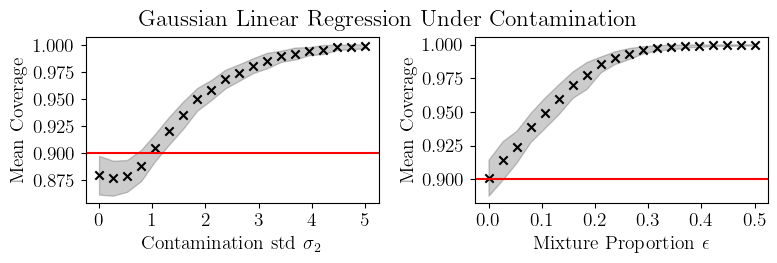

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].scatter(x=sigma_vals, y=sigma_means['cvg'], marker='x', color='black')
axs[0].fill_between(sigma_vals, sigma_means['cvg'] - sigma_stds['cvg'], sigma_means['cvg'] + sigma_stds['cvg'], alpha=0.2, color='black')
axs[0].axhline(0.9, color='red')
axs[0].set_xlabel('Contamination std $\\sigma_2$')
axs[0].set_ylabel('Mean Coverage')
axs[0].set_yticks(np.linspace(0.875, 1.0, 6))
axs[0].set_xticks(np.linspace(0.0, 5.0, 6))
axs[1].set_xticks(np.linspace(0.0, 0.5, 6))
axs[1].set_ylabel('Mean Coverage')
axs[1].set_yticks(np.linspace(0.9, 1.0, 5))
axs[1].scatter(x=eps_values, y=eps_means['cvg'], marker='x', color='black')
axs[1].fill_between(eps_values, eps_means['cvg'] - eps_stds['cvg'], eps_means['cvg'] + eps_stds['cvg'], alpha=0.2, color='black')

axs[1].set_xlabel('Mixture Proportion $\\epsilon$')
axs[1].axhline(0.9, color='red')
plt.suptitle('Gaussian Linear Regression Under Contamination', y=0.88)
plt.tight_layout()
plt.savefig('figures/regression_plot.pdf', format='pdf', dpi=1200, bbox_inches='tight')